# Regression Week 1: Simple Linear Regression

In this notebook we will use data on house sales in King County to predict house prices using simple (one input) linear regression. You will:
* Use Turi Create SArray and SFrame functions to compute important summary statistics (instead using Pandas and sklearn)
* Write a function to compute the Simple Linear Regression weights using the closed form solution
* Write a function to make predictions of the output given the input feature
* Turn the regression around to predict the input given the output
* Compare two different models for predicting house prices



### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Load house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 
              'sqft_living15':float, 'grade':int, 'yr_renovated':int, 
              'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 
              'sqft_lot15':float, 'sqft_living':float, 'floors':str, 
              'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 
              'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}
sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict, index_col=0)
sales.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [3]:
sales.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot           int64
floors            object
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode           object
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

Relation between living area of house and it's price

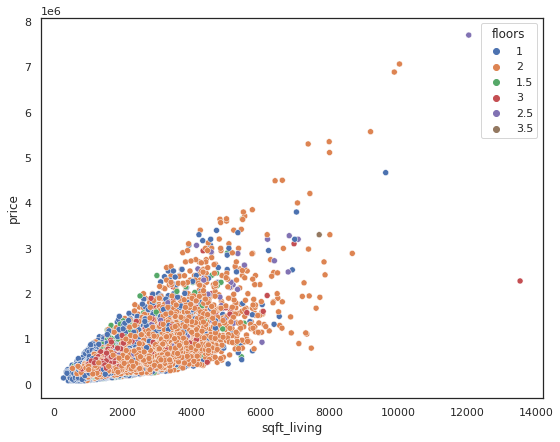

In [50]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(ax = ax, data=sales, x='sqft_living', y='price', hue='floors')

# Split data into training and testing

We use seed=0 so that everyone running this notebook gets the same results.  In practice, you may set a random seed (or let Turi Create pick a random seed for you).  

In [4]:
# normally
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# but for the quiz I will be using the training and testing data provided
train_data = pd.read_csv('kc_house_train_data.csv', dtype=dtype_dict, index_col=0)
train_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0


In [5]:
test_data = pd.read_csv('kc_house_test_data.csv', dtype=dtype_dict, index_col=0)
test_data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
114101516,20140528T000000,310000.0,3.0,1.0,1430.0,19901,1.5,0,0,4,7,1430,0,1927,0,98028,47.7558,-122.229,1780.0,12697.0
9297300055,20150124T000000,650000.0,4.0,3.0,2950.0,5000,2,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140.0,4000.0
1202000200,20141103T000000,233000.0,3.0,2.0,1710.0,4697,1.5,0,0,5,6,1710,0,1941,0,98002,47.3048,-122.218,1030.0,4705.0
8562750320,20141110T000000,580500.0,3.0,2.5,2320.0,3980,2,0,0,3,8,2320,0,2003,0,98027,47.5391,-122.070,2580.0,3980.0
7589200193,20141110T000000,535000.0,3.0,1.0,1090.0,3000,1.5,0,0,4,8,1090,0,1929,0,98117,47.6889,-122.375,1570.0,5080.0


# Useful SFrame summary functions

In order to make use of the closed form solution as well as take advantage of turi create's built in functions we will review some important ones. In particular:
* Computing the sum of an SArray
* Computing the arithmetic average (mean) of an SArray
* multiplying SArrays by constants
* multiplying SArrays by other SArrays

(*) I will be using pandas instead and not turi create as mentioned in the course

In [6]:
# Let's compute the mean of the House Prices in King County in 2 different ways.
prices = sales['price'] # extract the price column of the sales SFrame -- this is now a (pd.Series)

# recall that the arithmetic average (the mean) is the sum of the prices divided by the total number of houses:
sum_prices = prices.sum()
num_houses = len(prices)
avg_price_1 = sum_prices/num_houses
avg_price_2 = prices.mean() # if you just want the average, the .mean() function
print("average price via method 1: " + str(avg_price_1))
print("average price via method 2: " + str(avg_price_2))

average price via method 1: 540088.1417665294
average price via method 2: 540088.1417665294


As we see we get the same answer both ways

In [7]:
# or
sales['price'].mean()

540088.1417665294

In [8]:
# Let's compute the sum of squares of price
prices_squared = prices*prices
sum_prices_squared = prices_squared.sum()
print(f"the sum of price squared is: {sum_prices_squared}")

the sum of price squared is: 9217325138472070.0


Aside: The python notation x.xxe+yy means x.xx \* 10^(yy). e.g 100 = 10^2 = 1*10^2 = 1e2 

# Build a generic simple linear regression function 


Complete the following function (or write your own) to compute the simple linear regression slope and intercept:

numerator = (mean of X * Y) - (mean of X)*(mean of Y)

denominator = (mean of X^2) - (mean of X)*(mean of X)

intercept = (mean of Y) - slope * (mean of X)

In [34]:
def simple_linear_regression(input_feature, output):
    x_mean = input_feature.mean()
    y_mean = output.mean()
    x_y_mean = (input_feature * output).mean()
    x_square_mean = np.square(input_feature).mean()

    slope = (x_y_mean - (x_mean * y_mean)) / (x_square_mean - (x_mean * x_mean))


    intercept = y_mean - (slope*x_mean)
    return (intercept, slope)

We can test that our function works by passing it something where we know the answer. In particular we can generate a feature and then put the output exactly on a line: output = 1 + 1\*input_feature then we know both our slope and intercept should be 1

In [36]:
test_feature = np.arange(5)
test_output = 1 + 1*test_feature
(test_intercept, test_slope) =  simple_linear_regression(test_feature, test_output)
print(f'Intercept: {test_intercept}')
print(f'Slope: {test_slope}')

Intercept: 1.0
Slope: 1.0


Now that we know it works let's build a regression model for predicting price based on sqft_living. Rembember that we train on train_data!

In [37]:
sqft_intercept, sqft_slope = simple_linear_regression(train_data['sqft_living'], train_data['price'])

print(f"Intercept:   {sqft_intercept}")
print(f"Slope:   {sqft_slope}")

Intercept:   -47116.07907289488
Slope:   281.95883963034294


# Predicting Values

Now that we have the model parameters: intercept & slope we can make predictions. Using SArrays it's easy to multiply an SArray by a constant and add a constant value. Complete the following function to return the predicted output given the input_feature, slope and intercept:

In [51]:
def get_regression_predictions(input_feature, intercept, slope):
    # calculate the predicted values:
    predicted_values = slope*input_feature + intercept
    return predicted_values

Now that we can calculate a prediction given the slope and intercept let's make a prediction. Use (or alter) the following to find out the estimated price for a house with 2650 squarefeet according to the squarefeet model we estiamted above.

**Quiz Question: Using your Slope and Intercept from (4), What is the predicted price for a house with 2650 sqft?**

In [53]:
my_house_sqft = 2650
estimated_price = get_regression_predictions(my_house_sqft, sqft_intercept, sqft_slope)
print(f"The estimated price for a house with {my_house_sqft} squarefeet is {estimated_price:.2f}")

The estimated price for a house with 2650 squarefeet is 700074.85


# Residual Sum of Squares

Now that we have a model and can make predictions let's evaluate our model using Residual Sum of Squares (RSS). Recall that RSS is the sum of the squares of the residuals and the residuals is just a fancy word for the difference between the predicted output and the true output. 

Complete the following (or write your own) function to compute the RSS of a simple linear regression model given the input_feature, output, intercept and slope:

In [54]:
def get_residual_sum_of_squares(input_feature, output, intercept, slope):

    predictions = get_regression_predictions(input_feature, intercept, slope)
    diff = output - predictions
    squared = diff * diff
    RSS = squared.sum()

    return(RSS)

Let's test our get_residual_sum_of_squares function by applying it to the test model where the data lie exactly on a line. Since they lie exactly on a line the residual sum of squares should be zero!

In [55]:
print(get_residual_sum_of_squares(test_feature, test_output, test_intercept, test_slope))# should be 0.0

0.0


Now use your function to calculate the RSS on training data from the squarefeet model calculated above.

**Quiz Question: According to this function and the slope and intercept from the squarefeet model What is the RSS for the simple linear regression using squarefeet to predict prices on TRAINING data?**

In [58]:
rss_prices_on_sqft = get_residual_sum_of_squares(train_data['sqft_living'], train_data['price'], sqft_intercept, sqft_slope)
print(f'The RSS of predicting Prices based on Square Feet is: {rss_prices_on_sqft}')

The RSS of predicting Prices based on Square Feet is: 1201918354177283.0


# Predict the squarefeet given price

What if we want to predict the squarefoot given the price? Since we have an equation y = a + b\*x we can solve the function for x. So that if we have the intercept (a) and the slope (b) and the price (y) we can solve for the estimated squarefeet (x).

Complete the following function to compute the inverse regression estimate, i.e. predict the input_feature given the output.

In [57]:
def inverse_regression_predictions(output, intercept, slope):
    
    estimated_feature = (output - intercept) / slope
    return estimated_feature

Now that we have a function to compute the squarefeet given the price from our simple regression model let's see how big we might expect a house that costs $800,000 to be.

**Quiz Question: According to this function and the regression slope and intercept from (3) what is the estimated square-feet for a house costing $800,000?**

In [59]:
my_house_price = 800000
estimated_squarefeet = inverse_regression_predictions(my_house_price, sqft_intercept, sqft_slope)
print(f"The estimated squarefeet for a house worth {my_house_price:.2f} is {estimated_squarefeet}")

The estimated squarefeet for a house worth 800000.00 is 3004.3962451522752


# New Model: estimate prices from bedrooms

We have made one model for predicting house prices using squarefeet, but there are many other features in the sales Data. 
Use your simple linear regression function to estimate the regression parameters from predicting Prices based on number of bedrooms. Use the training data!

In [60]:
# Estimate the slope and intercept for predicting 'price' based on 'bedrooms'
beds_intercept, beds_slope = simple_linear_regression(train_data['bedrooms'], train_data['price'])
print(f'Slope: {beds_slope}, intercept: {beds_intercept}')

Slope: 127588.95293398833, intercept: 109473.17762295791


# Test your Linear Regression Algorithm

Now we have two models for predicting the price of a house. How do we know which one is better? Calculate the RSS on the TEST data (remember this data wasn't involved in learning the model). Compute the RSS from predicting prices using bedrooms and from predicting prices using squarefeet.

**Quiz Question: Which model (square feet or bedrooms) has lowest RSS on TEST data? Think about why this might be the case.**

In [61]:
# Compute RSS when using bedrooms on TEST data:
rss_prices_on_beds = get_residual_sum_of_squares(test_data['bedrooms'], test_data['price'], beds_intercept, beds_slope)
print(f'The RSS of predicting Prices based on Square Feet is: {rss_prices_on_beds}')

The RSS of predicting Prices based on Square Feet is: 493364585960301.0


In [62]:
# Compute RSS when using squarefeet on TEST data:
rss_prices_on_sqft = get_residual_sum_of_squares(test_data['sqft_living'], test_data['price'], sqft_intercept, sqft_slope)
print(f'The RSS of predicting Prices based on Square Feet is: {rss_prices_on_sqft}')

The RSS of predicting Prices based on Square Feet is: 275402933617812.16


In [63]:
rss_prices_on_beds > rss_prices_on_sqft

True

In [66]:
rss_prices_on_sqft / test_data.shape[0]

65122471888.8182

In [67]:
from sklearn.metrics import mean_squared_error

In [68]:
mean_squared_error(test_data['price'], get_regression_predictions(test_data['sqft_living'], sqft_intercept, sqft_slope))

65122471888.8182

## Comparing with sklearn

In [69]:
simple_model = LinearRegression()
simple_model.fit(train_data[['sqft_living']], train_data['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
preds = simple_model.predict(test_data[['sqft_living']])

In [71]:
mean_squared_error(test_data['price'], preds)

65122471888.81819